### ------------------ Module 2: Machine Learning ------------------

- What: Train Model and perform analysis
- Who : Code from Kevin.
- Updates : Weights to capture skew bias, Rolling validation, max drawdown with model output       
- When: 18 August 2022   

$\color{red}{\text{Define Parameters:}}$

In [ ]:
# Path to previously collected data
path='..\\Modules\\Data\\AlgoRun\\'

print('* Path to data:', path)

#### 1. Load some key libaries

In [2]:
import numpy as np
import pandas as pd
from hurst import compute_Hc, random_walk
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import  metrics
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import  date,datetime

# Little function to keep track of code execution.
def Keep_Track():
    print("Executed successfully. " + datetime.now().strftime("%a %d %b @ %H:%M:%S") + "\n")
    
Keep_Track()

Executed successfully. Sat 20 Aug @ 11:44:32



A couple of functions needed

In [3]:
# Shifts an array    
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = 0
        e[n:] = xs[:-n]
    return ((e==1) | (xs==1))*1

# Extracts algo run times from all possible runs and block
# E.g. All_Runs = [0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,1,0,0,0]
#                      run 1         run 2     run 3
# Blocks = [1,0,1] (there are only 3 runs) (i.e. model output forecasts)
# returns         [0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0] i.e. 2nd run removed
# Note the shift is needed due to some fiddly pieces to pick up return data.
def Get_Algo_Runs(All_Runs, Blocks):

    Started = False
    Skipping = False
    Block_Counter = 0
    
    # Collect model results
    Model_Run = np.empty(0)

    for indx,i in enumerate(All_Runs):
        
        # The start of a trade and it is a trade we are keeping
        if i == 1 and Blocks[Block_Counter] == 1:
            Started = True

        # The start of a trade we are ignoring
        if i == 1 and Blocks[Block_Counter] == 0:
            Skipping = True

        # We are skipping and the trade has finished    
        if i == 0 and Skipping:
            Skipping = False
            Block_Counter = Block_Counter+1
        
        # We have started and the trade has ended.
        if i == 0 and Started:
            Started = False
            Block_Counter = Block_Counter+1     

        if Started:
            Model_Run = np.append(Model_Run,1)
        else:
            Model_Run = np.append(Model_Run,0)
        
    return shift(Model_Run,1) 

Keep_Track()

Executed successfully. Sat 20 Aug @ 11:44:34



#### 2. Define the class

In [38]:
# Class definition from Kevin with various additions to compute max drawdown etc.

# Class to create the features from the data.
class Features(object):
    '''
    class to take in OHLC data and generate features
    '''

    @staticmethod
    def cal_close_avg(df, w):
        # Current close/avg
        d = {}
        for i in w:
            ds = (df.Close / (df.Close.rolling(i).mean()))
            d[f'FactorCurCloseDivAvg_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_volume_avg(df, w):
        # Current volume/avg
        d = {}
        for i in w:
            ds = (df.Volume / (df.Volume.rolling(i).mean()))
            d[f'FactorCurVolumeDivAvg_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_bk_return(df, w):
        # Period return up to now
        d = {}
        for i in w:
            ds = df.Close.pct_change(i)
            d[f'FactorBackReturn_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_fwd_return(df, w):
        # Period forward return up to w
        d = {}
        for i in w:
            ds = df.Close.pct_change(i).shift(-i)
            d[f'FactorFwdReturn_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_high_low(df, w):
        # rolling high/rolling low
        d = {}
        for i in w:
            ds = df.High.rolling(i).max() / df.Low.rolling(i).min()
            d[f'FactorHighDivLow_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_max_mean(df, w):
        # rolling high/rolling mean
        d = {}
        for i in w:
            ds = df.High.rolling(i).max() / df.Close.rolling(i).mean()
            d[f'FactorMaxDivMean_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_min_mean(df, w):
        # rolling min/rolling mean
        d = {}
        for i in w:
            ds = df.Low.rolling(i).min() / df.Close.rolling(i).mean()
            d[f'FactorMinDivMean_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_max_mean_volume(df, w):
        # rolling high/rolling mean for volume
        d = {}
        for i in w:
            ds = df.Volume.rolling(i).max() / df.Volume.rolling(i).mean()
            d[f'FactorMaxDivMeanVolume_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_min_mean_volume(df, w):
        # rolling min/rolling mean for volume
        d = {}
        for i in w:
            ds = df.Volume.rolling(i).min() / df.Volume.rolling(i).mean()
            d[f'FactorMinDivMeanVolume_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def cal_std(df, w):
        # rolling std
        d = {}
        for i in w:
            ds = df.Close.rolling(i).std()
            d[f'FactorStd_{i}'] = ds
        return pd.concat(d, axis=1)

    @staticmethod
    def Closing(df, w):
        # rolling std
        d = {}
        for i in w:
            ds = df.Close.shift(i)
            d[f'FactorClose_{i}'] = ds

        # Include current by default
        d[f'FactorClose_{0}'] = df.Close
        return pd.concat(d, axis=1)

    @staticmethod
    def Volume(df, w):
        # rolling std
        d = {}
        for i in w:
            ds = df.Volume.shift(i)
            d[f'FactorVolume_{i}'] = ds

        # Include current by default
        d[f'FactorVolume_{0}'] = df.Volume
        return pd.concat(d, axis=1)

    @staticmethod
    def r_zscore(df, w):
        # z_score Tina
        d = {}
        for i in w:
            ds = (np.log(df.Volume) - np.log(df.Volume).rolling(i).mean()) / np.log(df.Volume).rolling(i).std()
            d[f'FactorZ_Volume_{i}'] = ds

        return pd.concat(d, axis=1)

    @staticmethod
    def Parkinson(df, w):
        # z_score Tina
        d = {}

        for i in w:
            ds = np.log(df.High / df.Low) ** 2
            d[f'FactorParkinson_{i}'] = 0.5 * np.sqrt(ds.rolling(i).sum()) / np.sqrt(np.log(2) * i / (365 * 1440))

        return pd.concat(d, axis=1)

    @staticmethod
    def Hurst(df, w):
        d = {}
        Hurst = lambda x: compute_Hc(x, kind='price')[0]

        w = [180, 360]

        for i in w:
            if i > 100:  # else hurst function fails
                d[f'FactorHurst{i}'] = df.Close.rolling(i).apply(Hurst)

        return pd.concat(d, axis=1)

    @staticmethod
    def generate_factors(df_panel, factor_functions, w):
        '''
        generate factors on panel data with rolling window w
        '''
        l = []
        for f in factor_functions:
            #factor = df_panel.groupby('Ticker').apply(f, w)
            factor = f(df_panel,w)
            l.append(factor)
        return pd.concat(l, axis=1)

# Bostock:  Adjusted the code here to remove na's from specific columns    
    def generate_features(self, data,factor_functions,lag):
        data_features = Features.generate_factors(data, factor_functions, lag)
        combine = pd.concat([data, data_features], axis=1)
        data_ml = combine
#         data_ml = combine[~combine['trade_return'].isna()].dropna()
        
        # Need to be more careful about which col to remove na from
        # Later we will select the feature fields
#         data_ml = combine[~combine['trade_return'].isna()]
        
        #Remove missing values in the features just generated column
        # These must be removed for ml to use them
        self.data_ml = data_ml.dropna(subset = data_features.columns)
        
#         print('In gen features, first self.data after feature nas dropped',len((self.data_ml['trade_return'].dropna())))
    
        # For ml use the trade return record (this is what is used to build the categorical variable)
        data_ml = self.data_ml.dropna(subset = ['trade_return'])
        
#         print('In gen features, data_ml after na dropped',len(data_ml['trade_return']))
        
#         data_ml = data_ml.dropna(subset = data_ml.columns.difference(['trade_return_lag','Performance']))
        
        return data_ml.copy()      
    
class MachineLearning(object):
   
    # Initialise with the data
    def __init__(self,data):
        
        self.data = data
               
        # Keep everything here
        self.All_Data = data
    
    # Generate the features
    def GenerateFeature(self,lag,factor_functions,return_threhold):
        self.data=Features.generate_features(self, self.data, factor_functions, lag)
        
        # Create the target for the training
        self.data['results'] = np.where(self.data.trade_return > return_threhold, 1, 0)
    
    def RunModel(self,max_depth,n_estimators,random_state,IndexField,Forecast_Field,Features_Field,start,mid,end):
          
        
        self.Train, self.TrainX, self.TrainY, self.Test, self.TestX, self.TestY = MachineLearning.Train_Test_Build(self.data, IndexField,
                                                                                     Features_Field,
                                                                                     Forecast_Field, start,
                                                                                     mid,
                                                                                     end)
        
#         self.Model = RandomForestClassifier(max_depth=max_depth, random_state=random_state, n_estimators=n_estimators)
        # Add in class weights to manange skew in data.
        self.Model = RandomForestClassifier(max_depth=max_depth, 
                                            random_state=random_state, 
                                            n_estimators=n_estimators,
                                            class_weight = 'balanced')
        
        self.Model.fit(self.TrainX, self.TrainY)
        print("Model trained")
        print("-------------")
        # print("Estimators :", Estimators)
        print("Features   :", self.Model.n_features_in_)
        # print("OOB        :", Model.oob_score_)

        # Generate some forecasts
        self.ForecastsTrainY = self.Model.predict(self.TrainX)
        self.ForecastsTestY = self.Model.predict(self.TestX)

        Mat = confusion_matrix(self.TestY, self.ForecastsTestY)
        print('')
        print('* Testing set')
        MachineLearning.Metrics(Mat)

        Mat = confusion_matrix(self.TrainY, self.ForecastsTrainY)
        print('')
        print('* Training set')
        MachineLearning.Metrics(Mat)
        
        metrics.plot_confusion_matrix(self.Model,self.TestX,self.TestY)
        
        #TODO: Allow to save this somewhere else (Paul)
#         plt.savefig('MeanRevert/Results/ConfusionMatrix.png')
        self.RecallTest = metrics.recall_score(self.TestY,self.ForecastsTestY)
        self.PrecisionTest = metrics.precision_score(self.TestY,self.ForecastsTestY)
        self.F1Test = metrics.f1_score(self.TestY,self.ForecastsTestY)
        self.AccuracyTest = metrics.accuracy_score(self.TestY,self.ForecastsTestY)
        self.AucTest = metrics.roc_auc_score(self.TestY,self.Model.predict_proba(self.TestX)[:,1])
        self.TrainSkew = np.sum(self.TrainY)/len(self.TrainY)
        self.TestSkew = np.sum(self.TestY)/len(self.TestY)
        self.TrainLen = len(self.TrainX)
        self.TestLen = len(self.TestX)
        #print(metrics.classification_report(self.TestY, self.ForecastsTestY))
        
        # Calculate maxdd etc.
        # Create a copy to use
        Bostock_Temp = self.data_ml
        
#         Bostock_Temp = Bostock_Temp.loc[mid:end] # This filters differently
        Bostock_Temp = Bostock_Temp[(Bostock_Temp['Open Time'] >= mid)  & (Bostock_Temp['Open Time'] < end)]
    
        Bostock_Temp = Bostock_Temp.set_index('Open Time')
        
#         print('self.ml after filter', len((Bostock_Temp['trade_return'].dropna())))
        ####    
#         Indicator = ((Bostock_Temp['trade_return'].dropna() > Threshold)*1).values
        # Use the model output as the indicator to compute maxdd etc using model output
        Indicator = self.ForecastsTestY
        
        # -----------------
        # The actual algo run results
#         print('Results length:',len(Bostock_Temp.dropna(subset = ['trade_return'])))
#         print('Results length:',len(Indicator))
        
        Res = Bostock_Temp.dropna(subset = ['trade_return'])['trade_return']
        self.model_expectation = np.mean(Res[Indicator == 1])
        self.expectation = np.mean(Res)
        
        # -----------------
    
        # The earliest date in the split that starts a position.
        Earliest_Date = np.min((Bostock_Temp['trade_return_lag'].reset_index().dropna())['Open Time'])

        # Set all positions prior to this to first date to zero 
        Bostock_Temp.loc['2001-06-01':Earliest_Date,  'position'] = 0

        # Extract all possible runs    
        All_Runs = ((~(Bostock_Temp['position'] == 0))*1).values

        # Calculate the Indicator run.
        Bostock_Temp['Indicator_Run'] = Get_Algo_Runs(All_Runs, Indicator)   
        ####    
        
        # Resample to calculate daily returns
#         daily_return = Bostock_Temp['strategy'].resample('D').agg(lambda x: (x + 1).prod() - 1)
        daily_return = (Bostock_Temp['strategy'] * (Bostock_Temp['Indicator_Run'])).resample('D').agg(lambda x: (x + 1).prod() - 1)

        
        # Calculate cum returns
        cum_return = (1+daily_return).cumprod()
        
        if np.std(daily_return) == 0:
            self.sharpe = 0
        else:
            self.sharpe = np.mean(daily_return) / np.std(daily_return) * (252 ** 0.5)
        
        def calc_drawdown(cum_rets):
            # Calculate the running maximum
            running_max = np.maximum.accumulate(cum_rets.dropna())

            # Ensure the value never drops below 1
            running_max[running_max < 1] = 1

            # Calculate the percentage drawdown
            drawdown = (cum_rets) / running_max - 1
            return drawdown

        drawdown = calc_drawdown(cum_return)
        
        # Drawdown for the run.
        self.max_dd = drawdown.min()
    
    # Run over 
    def RollingValidation(self,max_depth,n_estimators,random_state,IndexField,Forecast_Field,Features_Field,start_date,end_date,train_period,test_period):
        
        dates = MachineLearning.GenerateDates(start_date, end_date, train_period, test_period)
        print(dates)
        results = []
        for i, d in dates.iterrows():
            start = d['start'].strftime('%Y-%m-%d')
            mid = d['mid'].strftime('%Y-%m-%d')
            end = d['end'].strftime('%Y-%m-%d')
            self.RunModel(max_depth,n_estimators,random_state,IndexField, Forecast_Field, Features_Field, start, mid, end)
            
            results.append([start, mid, end, self.PrecisionTest, self.RecallTest, self.F1Test, 
                            self.AccuracyTest, self.TestSkew,self.TrainLen, self.TestLen, 
                            self.sharpe, self.max_dd, self.model_expectation, self.expectation])            
        
        df = pd.DataFrame(results)
        df.columns = ['start', 'mid', 'end', 'precision', 'recall', 'f1', 'accuracy', 'testskew', 'trainlen',
                      'testlen', 'sharpe_model', 'max_dd_model','Model Exp', 'Exp']
        return df
    
    def RollingTesting(self,max_depth,n_estimators,random_state,IndexField,Forecast_Field,Features_Field,start_date,end_date,train_period,test_period):
        
        dates = MachineLearning.GenerateDates(start_date, end_date, train_period, test_period)

        for i, d in dates.iterrows():
            start = d['start'].strftime('%Y-%m-%d')
            mid = d['mid'].strftime('%Y-%m-%d')
            end = d['end'].strftime('%Y-%m-%d')
            self.RunModel(max_depth, n_estimators, random_state, IndexField, Forecast_Field, Features_Field, start, mid,
                          end)
            y_pred = self.Model.predict_proba(self.TestX)[:,1]
            self.data.loc[self.TestX.index,'predict']=y_pred

    def StressTest(self,n_depth,n_estimators):
        Train = np.empty(0)
        Test = np.empty(0)
        Depth_plot = np.empty(0)
        Tree_plot = np.empty(0)
        for Depth in n_depth:
            Model = RandomForestClassifier(max_depth=Depth, random_state=4021, n_estimators=50)
            Model.fit(self.TrainX, self.TrainY)

            Train_Error = np.sum(Model.predict(self.TrainX) == self.TrainY) / len(self.TrainY)
            Train = np.append(Train, Train_Error)

            Test_Error = np.sum(Model.predict(self.TestX) == self.TestY) / len(self.TestY)
            Test = np.append(Test, Test_Error)

            Depth_plot = np.append(Depth_plot, Depth)

        fig, axs = plt.subplots(2, 1)
        fig.set_size_inches(18.5, 10)

        # Create the  plot
        axs[0].scatter(Depth_plot, Train, s=10)

        axs[0].set_xlabel('Depth')
        axs[0].set_ylabel('Acc')
        axs[0].set_title('Train')
        axs[1].scatter(Depth_plot, Test, color='r', s=10)
        # axs[1].scatter(Depth_plot, Test_2, color = 'r', s= 10)
        axs[1].set_xlabel('Depth')
        axs[1].set_ylabel('Acc')
        axs[1].set_title('Test')
#         fig.savefig('MeanRevert/Results/depth.png')


        Train = np.empty(0)
        Test = np.empty(0)
        Depth_plot = np.empty(0)
        Tree_plot = np.empty(0)

        for tree in n_estimators:
            Model = RandomForestClassifier(max_depth=5, random_state=4021, n_estimators=tree)
            Model.fit(self.TrainX, self.TrainY)

            Train_Error = np.sum(Model.predict(self.TrainX) == self.TrainY) / len(self.TrainY)
            Train = np.append(Train, Train_Error)

            Test_Error = np.sum(Model.predict(self.TestX) == self.TestY) / len(self.TestY)
            Test = np.append(Test, Test_Error)

            Tree_plot = np.append(Tree_plot, tree)

        fig, axs = plt.subplots(2, 1)
        fig.set_size_inches(18.5, 10)

        # Create the  plot
        axs[0].scatter(Tree_plot, Train, s=10)

        axs[0].set_xlabel('Tree')
        axs[0].set_ylabel('Acc')
        axs[0].set_title('Train')
        axs[1].scatter(Tree_plot, Test, color='r', s=10)

        axs[1].set_xlabel('Tree')
        axs[1].set_ylabel('Acc')
        axs[1].set_title('Test')
#         fig.savefig('MeanRevert/Results/tree.png')
    
    def FeatureImportance(self):
        result_test = permutation_importance(self.Model, self.TestX, self.TestY, n_repeats=10,
                                             random_state=0,scoring=['f1','precision','recall', 'neg_log_loss'])
        fig = MachineLearning.Plot_Importance(result_test, 'f1', self.TrainX)

        return fig
    
    @staticmethod
    def Sample_Data(Data, Field=-1, UpperDate=-1, LowerDate=-1):
        # if no field is defined
        if Field == -1:
            # If no upper date is defined
            if UpperDate == -1:
                return Data[LowerDate:].sort_index()

            # If no lower date is not define
            if LowerDate == -1:
                return Data[:UpperDate].sort_index()

            return Data[LowerDate:UpperDate].sort_index()
        else:
            # If no upper date is defined
            if UpperDate == -1:
                return Data[(Data[Field] >= LowerDate)].sort_values(by=[Field])

            # If no lower date is not define
            if LowerDate == -1:
                return Data[(Data[Field] < UpperDate)].sort_values(by=[Field])
            
            return Data[(Data[Field] < UpperDate) & (Data[Field] >= LowerDate)].sort_values(by=[Field])

    @staticmethod
    def Train_Test_Build(Data,Index_Field ,Features_Field,Forecast_Field, Start, Mid, End):
        print('* Train / Test split with ~')
        print('         - Forecast field:', Forecast_Field)
        print('         - Training      :', Start, "->", Mid)
        print('         - Testing       :', Mid, "->", End)
        print('')

        # Filter by date to create train and test sets
        Train = MachineLearning.Sample_Data(Data, Field=Index_Field,LowerDate=Start, UpperDate=Mid)
        Test = MachineLearning.Sample_Data(Data, Field=Index_Field, LowerDate=Mid, UpperDate=End)

#         print('Test data:', Test)
        
        TrainX = Train[Features_Field]
        TestX = Test[Features_Field]
        TrainY = Train[[Forecast_Field]]
        TestY = Test[[Forecast_Field]]

        # summarise the % split
        print("* Test Length   :", len(TestY[Forecast_Field]))
        print("* Train Length  :", len(TrainY[Forecast_Field]))

        # # Convert to numpy arrays
        #TrainX = TrainX.values
        TrainY = TrainY.values.ravel()

        #TestX = TestX.values
        TestY = TestY.values.ravel()

        print('* X shape       :', np.shape(TrainX))
        print('* Y shape       :', np.shape(TrainY))

        print('Train Skew      : ', np.sum(TrainY) / len(TrainY))
        print('Test Skew       : ', np.sum(TestY) / len(TestY))
        

        return Train, TrainX, TrainY, Test, TestX, TestY
    
    @staticmethod
    def Metrics(Mat):

        P = Mat[1, 1] / (Mat[0, 1] + Mat[1, 1])
        R = Mat[1, 1] / (Mat[1, 0] + Mat[1, 1])

        print('  - Accuracy :', round((Mat[0, 0] + Mat[1, 1]) / (Mat[1, 1] + Mat[1, 0] + Mat[0, 1] + Mat[0, 0]), 3))
        print('  - Precision:', round(P, 3))
        print('  - Recall   :', round(R, 3))
        print('  - F1       :', round(2 * P * R / (P + R), 3))
    
    @staticmethod
    def Plot_Importance(Results_Test, Metric, Data):
        fig, axs = plt.subplots(1, 1, figsize=(15, 10))

        sorted_idx = Results_Test[Metric].importances_mean.argsort()
        axs.boxplot(Results_Test[Metric].importances[sorted_idx].T, vert=False, labels=Data.columns[sorted_idx])
        axs.set_title("Permutation Importances (Test set) " + Metric)
        fig.tight_layout()
        return fig
    
    @staticmethod
    def Compute_ROC(Model,DataX, DataY, step):
        # Compute the model probabilities for the data points.
        Prob = Model.predict_proba(DataX)
        DataY = DataY.astype(bool)

        # We need only keep one of the entries (since they sum to 1)
        # Keep the first one
        Prob = Prob[:, 1]

        TPR = np.empty(0)
        FPR = np.empty(0)
        Prec = np.empty(0)
        F1 = np.empty(0)
        XEnt = np.empty(0)

        # Then forecast over a range of thresholds and compare to actuals.
        for T in np.arange(0, 1, step):
            Prob_T = Prob > T

            # The compute metrics
            R = np.sum(Prob_T & DataY) / np.sum(DataY)
            TPR = np.append(TPR, R)

            FPR = np.append(FPR, np.sum(Prob_T & ~DataY) / (len(DataY) - np.sum(DataY)))
            P = np.sum(Prob_T & DataY) / (np.sum(Prob_T & ~DataY) + np.sum(Prob_T & DataY))
            Prec = np.append(Prec, P)
            F1 = np.append(F1, 2 * P * R / (R + P))
            # XEnt = np.append(XEnt, -np.sum(Prob_T * np.log(DataY + 0.00000000001)))

        return pd.DataFrame({'T': np.arange(0, 1, step), 'TPR': TPR, 'FPR': FPR, 'Prec': Prec, 'F1': F1})
    
    @staticmethod
    def plot_ROC(Curve_Test,Curve_Train):
        fig, axs = plt.subplots(2, 4)
        fig.set_size_inches(18.5, 10)

        min_range, max_range = 0.01, 50
        x = np.linspace(min_range, max_range, num=100)

        Best_T = Curve_Test['T'][np.argmax(Curve_Test['F1'])]
        F1 = Curve_Test['F1'][np.argmax(Curve_Test['F1'])]
        Precision = Curve_Test['Prec'][np.argmax(Curve_Test['F1'])]
        Recall = Curve_Test['TPR'][np.argmax(Curve_Test['F1'])]

        Best_T_Train = Curve_Train['T'][np.argmax(Curve_Train['F1'])]
        F1_Train = Curve_Train['F1'][np.argmax(Curve_Train['F1'])]
        Precision_Train = Curve_Train['Prec'][np.argmax(Curve_Train['F1'])]
        Recall_Train = Curve_Train['TPR'][np.argmax(Curve_Train['F1'])]

        # Create the  plot
        axs[0, 0].scatter(Curve_Test['FPR'], Curve_Test['TPR'], s=10)
        axs[0, 0].axline((0, 0), slope=1, color='r', lw=0.5)
        axs[0, 0].set_xlabel('FPR')
        axs[0, 0].set_ylabel('TPR')
        axs[0, 0].set_title('Test: ROC')
        axs[0, 0].set_xlim([0, 1])
        axs[0, 0].set_ylim([0, 1])

        axs[0, 1].scatter(Curve_Test['T'], Curve_Test['F1'], s=1.5)
        axs[0, 1].set_xlabel('Threshold')
        axs[0, 1].set_ylabel('F1')
        axs[0, 1].set_title('Test: F1 (' + str(round(F1, 3)) + ') T = ' + str(round(Best_T, 3)))
        axs[0, 1].axvline(x=Best_T, lw=0.5, alpha=0.5, color='b')
        axs[0, 1].set_xlim([0, 1])
        axs[0, 1].set_ylim([0, 1])

        axs[0, 2].scatter(Curve_Test['T'], Curve_Test['Prec'], s=1.5)
        axs[0, 2].axvline(x=Best_T, lw=0.5, alpha=0.5, color='b')
        axs[0, 2].set_xlabel('Threshold')
        axs[0, 2].set_ylabel('Precision')
        axs[0, 2].set_title('Test: Precision (' + str(round(Precision, 3)) + ')')
        axs[0, 2].set_xlim([0, 1])
        axs[0, 2].set_ylim([0, 1])

        axs[0, 3].scatter(Curve_Test['T'], Curve_Test['TPR'], s=1.5)
        axs[0, 3].axvline(x=Best_T, lw=0.5, alpha=0.5, color='b')
        axs[0, 3].set_xlabel('Threshold')
        axs[0, 3].set_ylabel('Recall')
        axs[0, 3].set_title('Test: Recall (' + str(round(Recall, 3)) + ')')
        axs[0, 3].set_xlim([0, 1])
        axs[0, 3].set_ylim([0, 1])

        axs[1, 0].scatter(Curve_Train['FPR'], Curve_Train['TPR'], s=10)
        axs[1, 0].axline((0, 0), slope=1, color='r', lw=0.5)
        axs[1, 0].set_xlabel('FPR')
        axs[1, 0].set_ylabel('TPR')
        axs[1, 0].set_title('Train: ROC')
        axs[1, 0].set_xlim([0, 1])
        axs[1, 0].set_ylim([0, 1])

        axs[1, 1].scatter(Curve_Train['T'], Curve_Train['F1'], s=1.5)
        axs[1, 1].axvline(x=Best_T_Train, lw=0.5, alpha=0.5, color='b')
        axs[1, 1].set_xlabel('Threshold')
        axs[1, 1].set_ylabel('F1')
        axs[1, 1].set_title('Train: F1 (' + str(round(F1_Train, 3)) + ') T = ' + str(round(Best_T_Train, 3)))
        axs[1, 1].set_xlim([0, 1])
        axs[1, 1].set_ylim([0, 1])

        axs[1, 2].scatter(Curve_Train['T'], Curve_Train['Prec'], s=1.5)
        axs[1, 2].axvline(x=Best_T_Train, lw=0.5, alpha=0.5, color='b')
        axs[1, 2].set_xlabel('Threshold')
        axs[1, 2].set_ylabel('Precision')
        axs[1, 2].set_title('Train: Precision (' + str(round(Precision_Train, 3)) + ')')
        axs[1, 2].set_xlim([0, 1])
        axs[1, 2].set_ylim([0, 1])

        axs[1, 3].scatter(Curve_Train['T'], Curve_Train['TPR'], s=1.5)
        axs[1, 3].axvline(x=Best_T_Train, lw=0.5, alpha=0.5, color='b')
        axs[1, 3].set_xlabel('Threshold')
        axs[1, 3].set_ylabel('Recall')
        axs[1, 3].set_title('Train: Recall (' + str(round(Recall_Train, 3)) + ')')
        axs[1, 3].set_xlim([0, 1])
        axs[1, 3].set_ylim([0, 1])
        return fig
    
    @staticmethod
    def GenerateDates(start,end,train_period,test_period):
        dates = pd.DataFrame()
        d = start
        interval=train_period+test_period
        while d + relativedelta(months=interval) <= end:
            # print(d,end)
            mid=d+relativedelta(months=train_period)
            ed = d + relativedelta(months=interval)
            dates = dates.append([[d, mid,ed]])
            d = d + relativedelta(months=test_period)
        dates.columns = ['start','mid', 'end']
        return dates

Keep_Track()

Executed successfully. Wed 24 Aug @ 15:58:23



#### 3. Usage

In [21]:
Res = data.dropna(subset = ['trade_return'])['trade_return']
np.mean(Res[Res > 0])

0.0029654191285102796

C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.04416598192276089
Test Skew       :  0.015335463258785943
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.957
  - Precision: 0.123
  - Recall   : 0.292
  - F1       : 0.173

* Training set
  - Accuracy : 0.921
  - Precision: 0.351
  - Recall   : 0.94
  - F1       : 0.511


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Max Drawdown     : -0.07421510641878137
* Sharpe           : -0.05519209402866741
* Expectation All  : -7.353948988319524e-06
* Expectation Model: 0.0005147390578280989


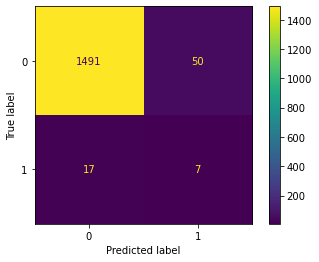

In [30]:
start = '2021-05-01'
mid ='2022-02-01'
end = '2022-05-01'

# data = pd.read_feather('./Data/backtesting_vt_Bostock.feather')
data = pd.read_feather('./Data/backtesting_vt_Bostock_2Y.feather')
lag = [60, 180]
return_threshold = 0.0008
return_threshold = 0.00128
return_threshold = 0.0015
return_threshold = 0.0075
max_depth = 6
n_estimators = 10
random_state = 101

factor_functions = [Features.cal_close_avg, Features.cal_bk_return, Features.cal_high_low, Features.cal_max_mean,
                    Features.cal_min_mean,
                    Features.cal_volume_avg, Features.cal_max_mean_volume, Features.cal_min_mean_volume,
                    Features.cal_std, Features.r_zscore, Features.Parkinson]


# Create the class
ml = MachineLearning(data)

# # Generate the features
ml.GenerateFeature(lag,factor_functions,return_threshold)

Forecast_Field = 'results'
Features_Field = [idx for idx in ml.data.columns if idx[:6] == 'Factor']


ml.RunModel(max_depth,n_estimators,random_state,'Open Time',Forecast_Field,Features_Field,start,mid,end)

print('* Max Drawdown     :', ml.max_dd)
print('* Sharpe           :', ml.sharpe)
print('* Expectation All  :', ml.expectation)
print('* Expectation Model:', ml.model_expectation)



$\color{blue}{\text{Testing:}}$

In [ ]:
# np.save('ModelOutput', ml.ForecastsTestY)
# ml.ForecastsTestY

#### 4. Stresses and rolling validation

C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6994658997534922
Test Skew       :  0.6849840255591054
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.584
  - Precision: 0.702
  - Recall   : 0.683
  - F1       : 0.692

* Training set
  - Accuracy : 0.709
  - Precision: 0.808
  - Recall   : 0.765
  - F1       : 0.786


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6920706655710764
Test Skew       :  0.6766773162939297
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.566
  - Precision: 0.706
  - Recall   : 0.616
  - F1       : 0.658

* Training set
  - Accuracy : 0.719
  - Precision: 0.796
  - Recall   : 0.798
  - F1       : 0.797


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.684264585045193
Test Skew       :  0.6702875399361022
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.539
  - Precision: 0.674
  - Recall   : 0.604
  - F1       : 0.637

* Training set
  - Accuracy : 0.703
  - Precision: 0.779
  - Recall   : 0.791
  - F1       : 0.785


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6756368118323747
Test Skew       :  0.6504792332268371
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.527
  - Precision: 0.66
  - Recall   : 0.563
  - F1       : 0.608

* Training set
  - Accuracy : 0.683
  - Precision: 0.767
  - Recall   : 0.762
  - F1       : 0.765


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6688578471651603
Test Skew       :  0.6383386581469649
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.537
  - Precision: 0.654
  - Recall   : 0.584
  - F1       : 0.617

* Training set
  - Accuracy : 0.682
  - Precision: 0.755
  - Recall   : 0.776
  - F1       : 0.765


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6585866885784717
Test Skew       :  0.6236421725239617
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.532
  - Precision: 0.641
  - Recall   : 0.566
  - F1       : 0.601

* Training set
  - Accuracy : 0.692
  - Precision: 0.76
  - Recall   : 0.778
  - F1       : 0.769


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.649342645850452
Test Skew       :  0.6083067092651757
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.512
  - Precision: 0.623
  - Recall   : 0.502
  - F1       : 0.556

* Training set
  - Accuracy : 0.685
  - Precision: 0.759
  - Recall   : 0.754
  - F1       : 0.756


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6372226787181594
Test Skew       :  0.5897763578274761
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.501
  - Precision: 0.612
  - Recall   : 0.421
  - F1       : 0.499

* Training set
  - Accuracy : 0.666
  - Precision: 0.752
  - Recall   : 0.711
  - F1       : 0.731


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6275677896466721
Test Skew       :  0.5680511182108626
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.496
  - Precision: 0.567
  - Recall   : 0.478
  - F1       : 0.519

* Training set
  - Accuracy : 0.662
  - Precision: 0.735
  - Recall   : 0.721
  - F1       : 0.728


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6164749383730485
Test Skew       :  0.552076677316294
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.506
  - Precision: 0.58
  - Recall   : 0.381
  - F1       : 0.46

* Training set
  - Accuracy : 0.647
  - Precision: 0.707
  - Recall   : 0.73
  - F1       : 0.718


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.6018898931799507
Test Skew       :  0.5297124600638977
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.526
  - Precision: 0.572
  - Recall   : 0.419
  - F1       : 0.483

* Training set
  - Accuracy : 0.66
  - Precision: 0.711
  - Recall   : 0.732
  - F1       : 0.721


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.5875102711585867
Test Skew       :  0.5073482428115016
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.528
  - Precision: 0.549
  - Recall   : 0.398
  - F1       : 0.461

* Training set
  - Accuracy : 0.668
  - Precision: 0.703
  - Recall   : 0.752
  - F1       : 0.727


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.5770336894001643
Test Skew       :  0.4830670926517572
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.554
  - Precision: 0.553
  - Recall   : 0.401
  - F1       : 0.465

* Training set
  - Accuracy : 0.665
  - Precision: 0.697
  - Recall   : 0.742
  - F1       : 0.719


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.5605998356614627
Test Skew       :  0.4645367412140575
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.565
  - Precision: 0.546
  - Recall   : 0.384
  - F1       : 0.451

* Training set
  - Accuracy : 0.664
  - Precision: 0.683
  - Recall   : 0.75
  - F1       : 0.715


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.543138866064092
Test Skew       :  0.43322683706070286
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.593
  - Precision: 0.541
  - Recall   : 0.4
  - F1       : 0.46

* Training set
  - Accuracy : 0.663
  - Precision: 0.679
  - Recall   : 0.72
  - F1       : 0.699


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.5281429745275267
Test Skew       :  0.40894568690095845
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.604
  - Precision: 0.52
  - Recall   : 0.423
  - F1       : 0.467

* Training set
  - Accuracy : 0.667
  - Precision: 0.668
  - Recall   : 0.734
  - F1       : 0.699


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.5104765817584224
Test Skew       :  0.38466453674121404
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.622
  - Precision: 0.511
  - Recall   : 0.44
  - F1       : 0.473

* Training set
  - Accuracy : 0.674
  - Precision: 0.659
  - Recall   : 0.749
  - F1       : 0.701


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.4926047658175842
Test Skew       :  0.3610223642172524
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.625
  - Precision: 0.479
  - Recall   : 0.434
  - F1       : 0.455

* Training set
  - Accuracy : 0.672
  - Precision: 0.639
  - Recall   : 0.765
  - F1       : 0.697


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.4763763352506163
Test Skew       :  0.34568690095846644
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.658
  - Precision: 0.505
  - Recall   : 0.471
  - F1       : 0.488

* Training set
  - Accuracy : 0.668
  - Precision: 0.629
  - Recall   : 0.736
  - F1       : 0.678


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.4580936729663106
Test Skew       :  0.32396166134185306
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.675
  - Precision: 0.498
  - Recall   : 0.452
  - F1       : 0.474

* Training set
  - Accuracy : 0.666
  - Precision: 0.611
  - Recall   : 0.748
  - F1       : 0.673


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.44309778142974526
Test Skew       :  0.3003194888178914
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.699
  - Precision: 0.499
  - Recall   : 0.474
  - F1       : 0.486

* Training set
  - Accuracy : 0.661
  - Precision: 0.594
  - Recall   : 0.743
  - F1       : 0.66


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.4264585045193098
Test Skew       :  0.2837060702875399
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.698
  - Precision: 0.469
  - Recall   : 0.502
  - F1       : 0.485

* Training set
  - Accuracy : 0.676
  - Precision: 0.593
  - Recall   : 0.772
  - F1       : 0.67


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.41002465078060807
Test Skew       :  0.26517571884984026
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.716
  - Precision: 0.466
  - Recall   : 0.501
  - F1       : 0.483

* Training set
  - Accuracy : 0.672
  - Precision: 0.574
  - Recall   : 0.769
  - F1       : 0.657


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.38989317995069844
Test Skew       :  0.2504792332268371
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.721
  - Precision: 0.449
  - Recall   : 0.49
  - F1       : 0.468

* Training set
  - Accuracy : 0.682
  - Precision: 0.568
  - Recall   : 0.779
  - F1       : 0.657


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.3722267871815941
Test Skew       :  0.23578274760383386
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.715
  - Precision: 0.418
  - Recall   : 0.528
  - F1       : 0.467

* Training set
  - Accuracy : 0.689
  - Precision: 0.559
  - Recall   : 0.778
  - F1       : 0.65


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-05-01

* Test Length   : 1565
* Train Length  : 4868
* X shape       : (4868, 22)
* Y shape       : (4868,)
Train Skew      :  0.3535332785538209
Test Skew       :  0.22555910543130991
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.723
  - Precision: 0.407
  - Recall   : 0.499
  - F1       : 0.448

* Training set
  - Accuracy : 0.696
  - Precision: 0.549
  - Recall   : 0.784
  - F1       : 0.646


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Executed successfully. Wed 24 Aug @ 15:46:51



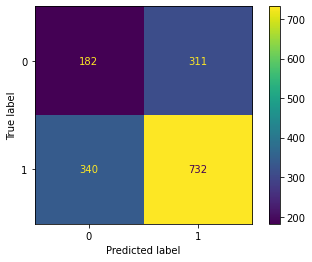

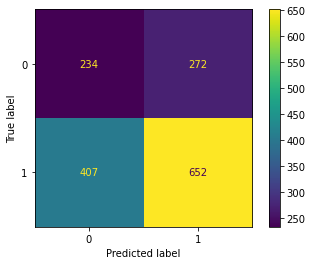

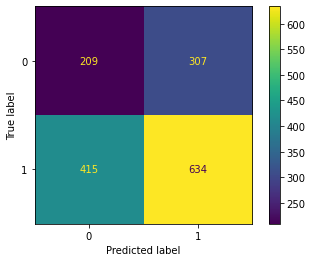

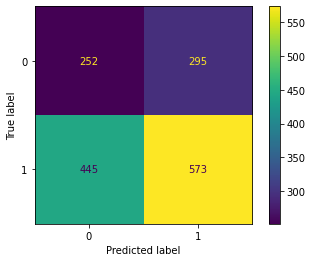

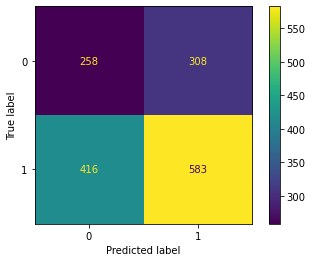

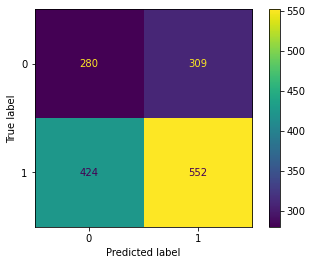

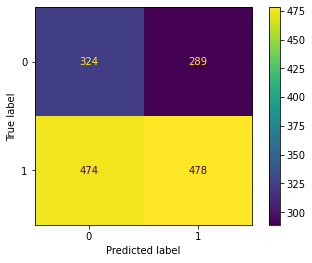

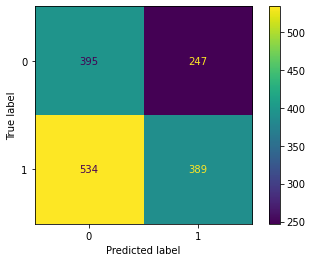

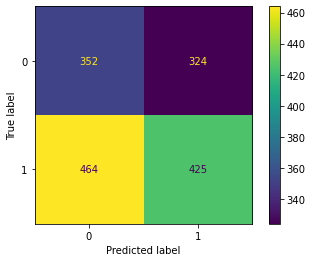

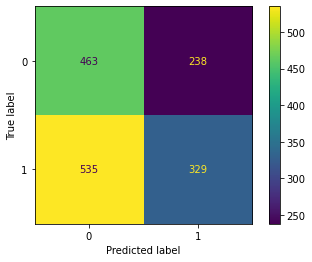

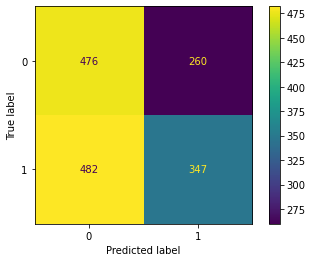

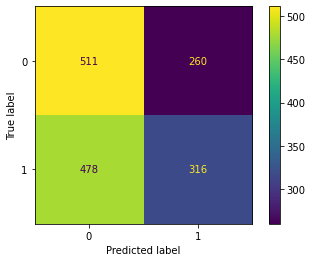

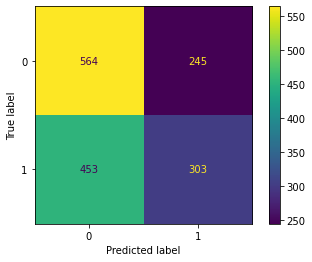

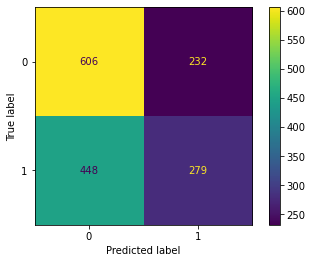

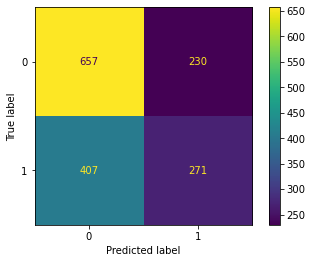

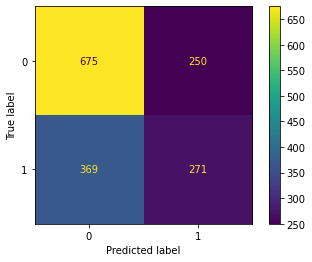

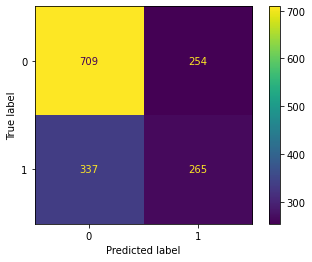

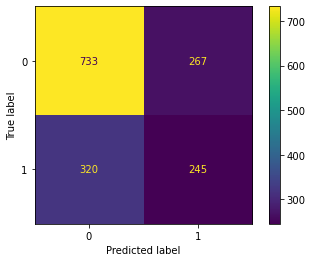

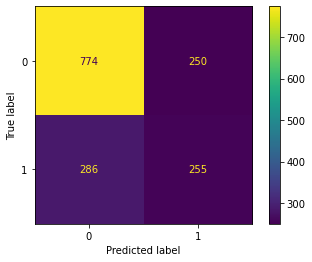

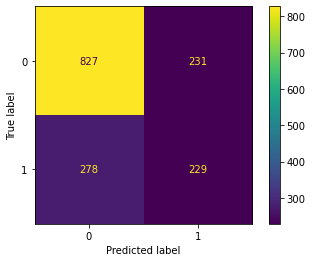

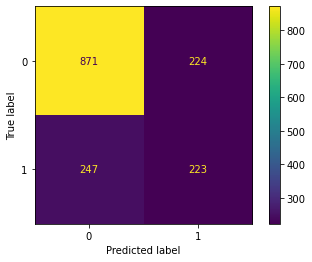

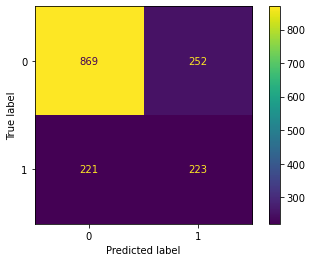

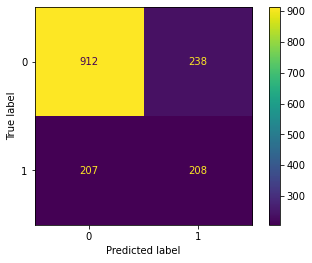

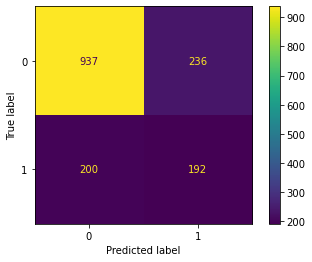

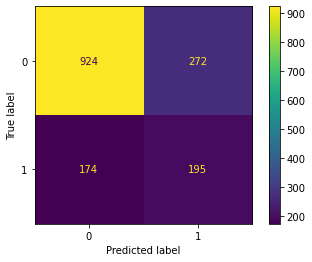

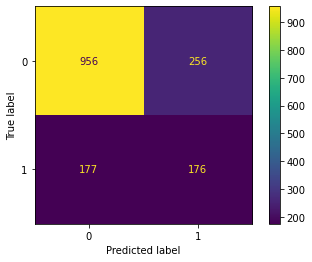

In [31]:
# Run some analysis over various thresholds
start = '2021-05-01'
mid ='2022-02-01'
end = '2022-05-01'

data = pd.read_feather('./Data/backtesting_vt_Bostock_2Y.feather')
lag = [60, 180]
random_state = 101
max_depth = 6
n_estimators = 10
random_state = 101

factor_functions = [Features.cal_close_avg, Features.cal_bk_return, Features.cal_high_low, Features.cal_max_mean,
                    Features.cal_min_mean,
                    Features.cal_volume_avg, Features.cal_max_mean_volume, Features.cal_min_mean_volume,
                    Features.cal_std, Features.r_zscore, Features.Parkinson]

Precision = np.empty(0)
Recall = np.empty(0)
Skew = np.empty(0)

Drawdown = np.empty(0)
Sharpe = np.empty(0)

Expect_Model = np.empty(0)
Expect_All = np.empty(0)

Stress_Range = np.arange(0,0.0026,0.0001)

# Create the class
for return_threhold in Stress_Range:

    ml = MachineLearning(data)

    # # Generate the features
    ml.GenerateFeature(lag,factor_functions,return_threhold)

    Forecast_Field = 'results'
    Features_Field = [idx for idx in ml.data.columns if idx[:6] == 'Factor']

    ml.RunModel(max_depth,n_estimators,random_state,'Open Time',Forecast_Field,Features_Field,start,mid,end)

    Precision = np.append(Precision,ml.PrecisionTest)
    Recall = np.append(Recall,ml.RecallTest)

    # Need skew
    Skew = np.append(Skew,np.sum(ml.TestY)/len(ml.TestY))
    
    # DD and Sharpe
    Drawdown = np.append(Drawdown,ml.max_dd)  
    Sharpe = np.append(Sharpe,ml.sharpe) 
    
    Expect_Model = np.append(Expect_Model,ml.model_expectation)  
    Expect_All = np.append(Expect_All,ml.expectation)  

    
    
Keep_Track()   

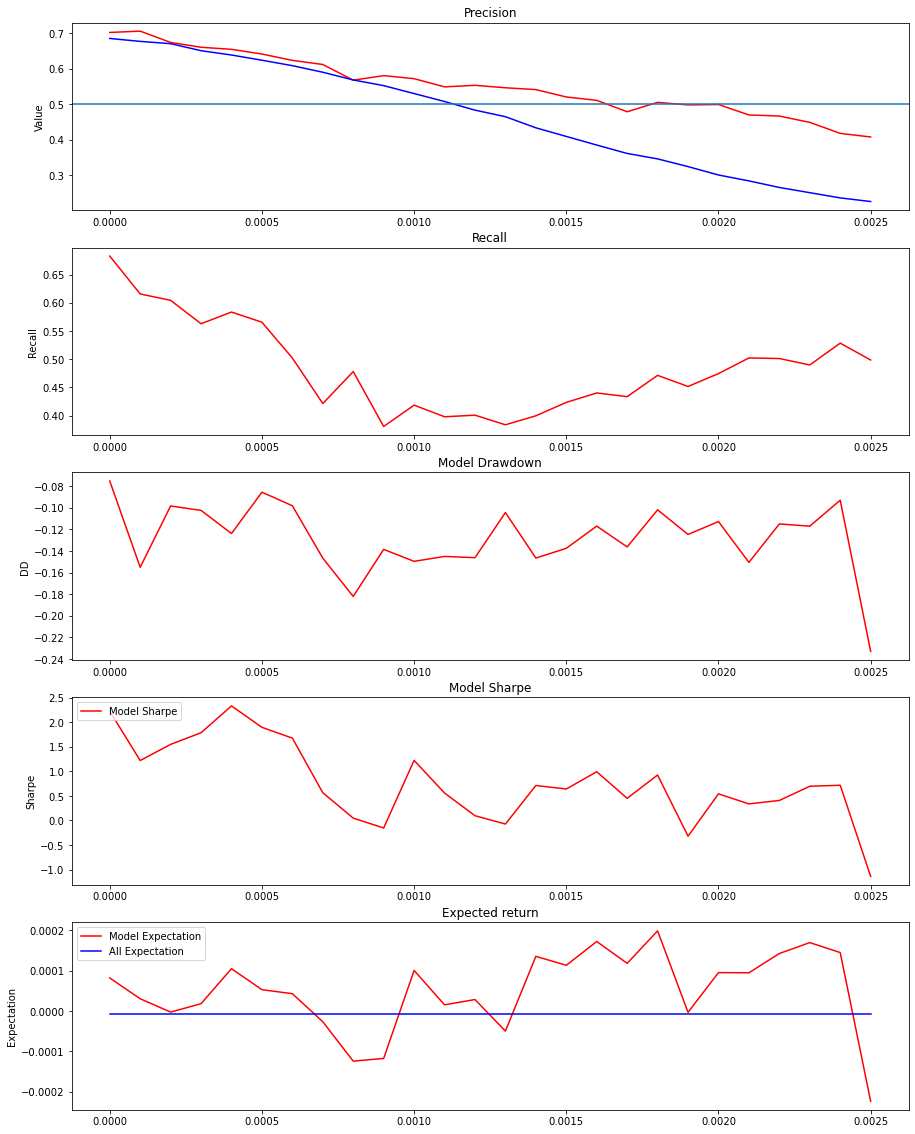

In [37]:
# Plot results
fig, axs = plt.subplots(5,1)
fig.set_size_inches(15, 20)


# Create the  plot
axs[0].plot(Stress_Range, Precision, color = 'r',label = 'Precision')
axs[0].plot(Stress_Range, Skew, color = 'b',label = 'Skew')
axs[0].axhline(y=0.5)

axs[0].set_ylabel('Value')
axs[0].set_title('Precision')
# axs[0].set_xlim([0,1])
# axs[0].set_ylim([-0.0006,0.0006])

axs[1].plot(Stress_Range, Recall, color = 'r',label = 'Recall')
axs[1].set_title('Recall')
axs[1].set_ylabel('Recall')
# axs[1].set_xlabel('Threshold')
# axs[1].set_title('Winning')
# axs[1].set_ylim([0.6,0.8])

axs[2].plot(Stress_Range, Drawdown,color = 'r',label = 'Model drawdown')

axs[2].set_ylabel('DD')
axs[2].set_title('Model Drawdown')
# axs[2].set_ylim([0,1000])

axs[3].plot(Stress_Range, Sharpe,color = 'r',label = 'Model Sharpe')

axs[3].set_ylabel('Sharpe')
axs[3].set_title('Model Sharpe')
# axs[2].set_ylim([0,1000])

axs[3].legend(loc='upper right')
axs[3].legend(loc='upper left')


axs[4].plot(Stress_Range, Expect_Model,color = 'r',label = 'Model Expectation')
axs[4].plot(Stress_Range, Expect_All,color = 'b',label = 'All Expectation')

axs[4].set_ylabel('Expectation')
axs[4].set_title('Expected return')
# axs[2].set_ylim([0,1000])

axs[4].legend(loc='upper right')
axs[4].legend(loc='upper left')


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


        start         mid         end
0  2020-08-01  2021-08-01  2021-09-01
0  2020-09-01  2021-09-01  2021-10-01
0  2020-10-01  2021-10-01  2021-11-01
0  2020-11-01  2021-11-01  2021-12-01
0  2020-12-01  2021-12-01  2022-01-01
0  2021-01-01  2022-01-01  2022-02-01
0  2021-02-01  2022-02-01  2022-03-01
0  2021-03-01  2022-03-01  2022-04-01
0  2021-04-01  2022-04-01  2022-05-01
0  2021-05-01  2022-05-01  2022-06-01
0  2021-06-01  2022-06-01  2022-07-01
0  2021-07-01  2022-07-01  2022-08-01
* Train / Test split with ~
         - Forecast field: results
         - Training      : 2020-08-01 -> 2021-08-01
         - Testing       : 2021-08-01 -> 2021-09-01

* Test Length   : 533
* Train Length  : 6492
* X shape       : (6492, 22)
* Y shape       : (6492,)
Train Skew      :  0.44115834873690696
Test Skew       :  0.4803001876172608
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.557
  - Precision: 0.534
  - Recall   : 0.609
  - F1       : 0.569

* Training set
  

C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2020-09-01 -> 2021-09-01
         - Testing       : 2021-09-01 -> 2021-10-01

* Test Length   : 533
* Train Length  : 6534
* X shape       : (6534, 22)
* Y shape       : (6534,)
Train Skew      :  0.4576063666972758
Test Skew       :  0.41088180112570355
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.583
  - Precision: 0.495
  - Recall   : 0.644
  - F1       : 0.56

* Training set
  - Accuracy : 0.669
  - Precision: 0.602
  - Recall   : 0.818
  - F1       : 0.694


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2020-10-01 -> 2021-10-01
         - Testing       : 2021-10-01 -> 2021-11-01

* Test Length   : 528
* Train Length  : 6561
* X shape       : (6561, 22)
* Y shape       : (6561,)
Train Skew      :  0.4708123761621704
Test Skew       :  0.3541666666666667
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.583
  - Precision: 0.416
  - Recall   : 0.439
  - F1       : 0.427

* Training set
  - Accuracy : 0.668
  - Precision: 0.612
  - Recall   : 0.801
  - F1       : 0.694


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2020-11-01 -> 2021-11-01
         - Testing       : 2021-11-01 -> 2021-12-01

* Test Length   : 521
* Train Length  : 6562
* X shape       : (6562, 22)
* Y shape       : (6562,)
Train Skew      :  0.48384638829625115
Test Skew       :  0.3857965451055662
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.599
  - Precision: 0.478
  - Recall   : 0.443
  - F1       : 0.46

* Training set
  - Accuracy : 0.658
  - Precision: 0.624
  - Recall   : 0.742
  - F1       : 0.678


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2020-12-01 -> 2021-12-01
         - Testing       : 2021-12-01 -> 2022-01-01

* Test Length   : 522
* Train Length  : 6563
* X shape       : (6563, 22)
* Y shape       : (6563,)
Train Skew      :  0.4817918634770684
Test Skew       :  0.3735632183908046
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.579
  - Precision: 0.437
  - Recall   : 0.446
  - F1       : 0.442

* Training set
  - Accuracy : 0.654
  - Precision: 0.621
  - Recall   : 0.726
  - F1       : 0.669


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-01-01 -> 2022-01-01
         - Testing       : 2022-01-01 -> 2022-02-01

* Test Length   : 527
* Train Length  : 6549
* X shape       : (6549, 22)
* Y shape       : (6549,)
Train Skew      :  0.47411818598259275
Test Skew       :  0.3700189753320683
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.628
  - Precision: 0.497
  - Recall   : 0.487
  - F1       : 0.492

* Training set
  - Accuracy : 0.659
  - Precision: 0.614
  - Recall   : 0.751
  - F1       : 0.676


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-02-01 -> 2022-02-01
         - Testing       : 2022-02-01 -> 2022-03-01

* Test Length   : 493
* Train Length  : 6504
* X shape       : (6504, 22)
* Y shape       : (6504,)
Train Skew      :  0.45817958179581797
Test Skew       :  0.3671399594320487
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.633
  - Precision: 0.5
  - Recall   : 0.536
  - F1       : 0.517

* Training set
  - Accuracy : 0.657
  - Precision: 0.6
  - Recall   : 0.75
  - F1       : 0.667


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-03-01 -> 2022-03-01
         - Testing       : 2022-03-01 -> 2022-04-01

* Test Length   : 545
* Train Length  : 6484
* X shape       : (6484, 22)
* Y shape       : (6484,)
Train Skew      :  0.4461752004935225
Test Skew       :  0.30458715596330277
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.701
  - Precision: 0.51
  - Recall   : 0.482
  - F1       : 0.495

* Training set
  - Accuracy : 0.663
  - Precision: 0.6
  - Recall   : 0.732
  - F1       : 0.66


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-04-01 -> 2022-04-01
         - Testing       : 2022-04-01 -> 2022-05-01

* Test Length   : 527
* Train Length  : 6465
* X shape       : (6465, 22)
* Y shape       : (6465,)
Train Skew      :  0.42753286929621037
Test Skew       :  0.2333965844402277
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.751
  - Precision: 0.466
  - Recall   : 0.447
  - F1       : 0.456

* Training set
  - Accuracy : 0.665
  - Precision: 0.583
  - Recall   : 0.765
  - F1       : 0.661


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-05-01 -> 2022-05-01
         - Testing       : 2022-05-01 -> 2022-06-01

* Test Length   : 539
* Train Length  : 6433
* X shape       : (6433, 22)
* Y shape       : (6433,)
Train Skew      :  0.40836312762319293
Test Skew       :  0.3525046382189239
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.638
  - Precision: 0.489
  - Recall   : 0.589
  - F1       : 0.535

* Training set
  - Accuracy : 0.662
  - Precision: 0.564
  - Recall   : 0.752
  - F1       : 0.645


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-06-01 -> 2022-06-01
         - Testing       : 2022-06-01 -> 2022-07-01

* Test Length   : 531
* Train Length  : 6377
* X shape       : (6377, 22)
* Y shape       : (6377,)
Train Skew      :  0.38654539752234596
Test Skew       :  0.4067796610169492
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.574
  - Precision: 0.484
  - Recall   : 0.713
  - F1       : 0.577

* Training set
  - Accuracy : 0.656
  - Precision: 0.537
  - Recall   : 0.803
  - F1       : 0.644


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


* Train / Test split with ~
         - Forecast field: results
         - Training      : 2021-07-01 -> 2022-07-01
         - Testing       : 2022-07-01 -> 2022-08-01

* Test Length   : 579
* Train Length  : 6364
* X shape       : (6364, 22)
* Y shape       : (6364,)
Train Skew      :  0.37539283469516027
Test Skew       :  0.4214162348877375
Model trained
-------------
Features   : 22

* Testing set
  - Accuracy : 0.547
  - Precision: 0.478
  - Recall   : 0.787
  - F1       : 0.594

* Training set
  - Accuracy : 0.657
  - Precision: 0.529
  - Recall   : 0.795
  - F1       : 0.635


C:\Program Files\Anaconda3\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Executed successfully. Wed 24 Aug @ 15:58:49



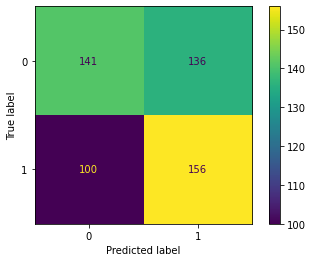

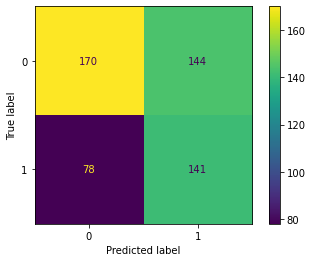

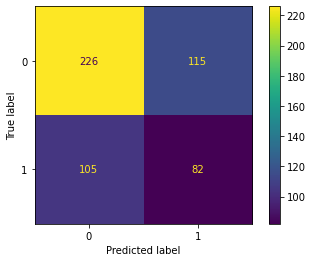

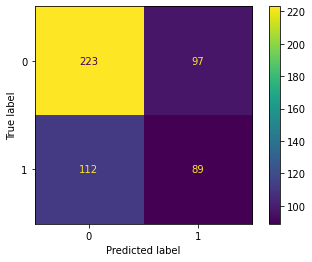

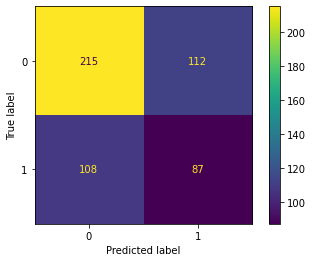

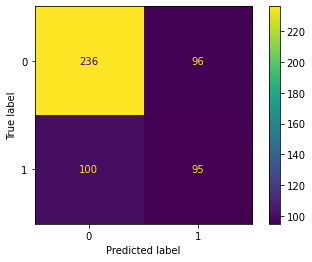

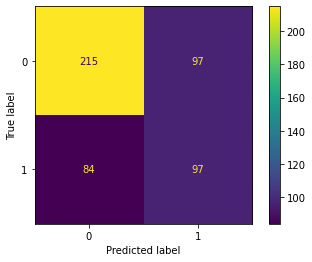

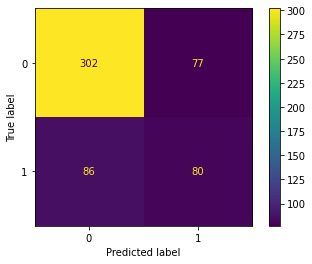

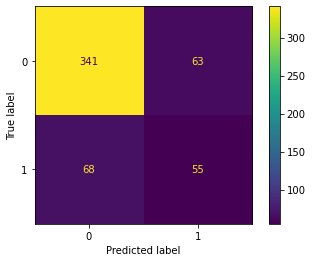

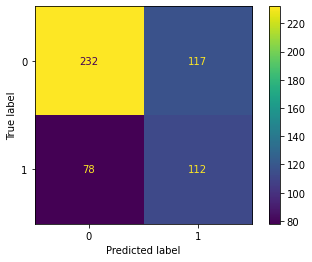

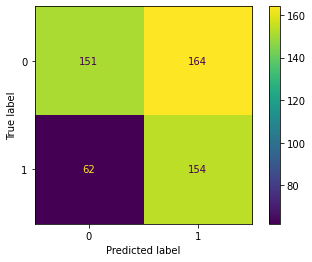

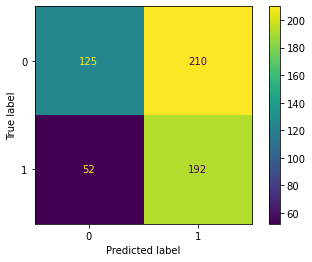

In [39]:
### Rolling validation.
start = '2020-08-01'
end = '2022-08-01'

data = pd.read_feather('./Data/backtesting_vt_Bostock_2Y.feather')
lag = [60, 180]
return_threhold = 0.002
max_depth = 6
n_estimators = 10
random_state = 101

factor_functions = [Features.cal_close_avg, Features.cal_bk_return, Features.cal_high_low, Features.cal_max_mean,
                    Features.cal_min_mean,
                    Features.cal_volume_avg, Features.cal_max_mean_volume, Features.cal_min_mean_volume,
                    Features.cal_std, Features.r_zscore, Features.Parkinson]

# Create the class
ml = MachineLearning(data)

# # Generate the features
ml.GenerateFeature(lag,factor_functions,return_threhold)

Forecast_Field = 'results'
Features_Field = [idx for idx in ml.data.columns if idx[:6] == 'Factor']

# ml.RunModel(max_depth,n_estimators,random_state,'Open Time',Forecast_Field,Features_Field,start,mid,end)
# Train 12mths validate 1month

Rolling_Results = ml.RollingValidation(max_depth,n_estimators,random_state,'Open Time',
                     Forecast_Field,Features_Field,
                     date(2020, 8, 1),date(2022, 8, 1), 12, 1)
        



Keep_Track()

In [40]:
Rolling_Results

,start,mid,end,precision,recall,f1,accuracy,testskew,trainlen,testlen,sharpe_model,max_dd_model,Model Exp,Exp
0,2020-08-01,2021-08-01,2021-09-01,0.534247,0.609375,0.569343,0.557223,0.480300,6492,533,3.851336,-0.059906,0.000440,0.000508
1,2020-09-01,2021-09-01,2021-10-01,0.494737,0.643836,0.559524,0.583490,0.410882,6534,533,0.508397,-0.092251,0.000086,0.000082
2,2020-10-01,2021-10-01,2021-11-01,0.416244,0.438503,0.427083,0.583333,0.354167,6561,528,1.046034,-0.053314,0.000015,-0.000020
3,2020-11-01,2021-11-01,2021-12-01,0.478495,0.442786,0.459948,0.598848,0.385797,6562,521,4.187813,-0.038526,0.000902,0.000497
4,2020-12-01,2021-12-01,2022-01-01,0.437186,0.446154,0.441624,0.578544,0.373563,6563,522,1.983189,-0.041533,0.000242,0.000148
5,2021-01-01,2022-01-01,2022-02-01,0.497382,0.487179,0.492228,0.628083,0.370019,6549,527,1.843994,-0.067889,0.000353,0.000166
6,2021-02-01,2022-02-01,2022-03-01,0.500000,0.535912,0.517333,0.632860,0.367140,6504,493,-3.129017,-0.179592,-0.001003,-0.000400
7,2021-03-01,2022-03-01,2022-04-01,0.509554,0.481928,0.495356,0.700917,0.304587,6484,545,1.652659,-0.125853,0.000559,0.000108
8,2021-04-01,2022-04-01,2022-05-01,0.466102,0.447154,0.456432,0.751423,0.233397,6465,527,-0.854562,-0.061004,0.000097,0.000240
9,2021-05-01,2022-05-01,2022-06-01,0.489083,0.589474,0.534606,0.638219,0.352505,6433,539,-0.855457,-0.099254,-0.000080,-0.000156


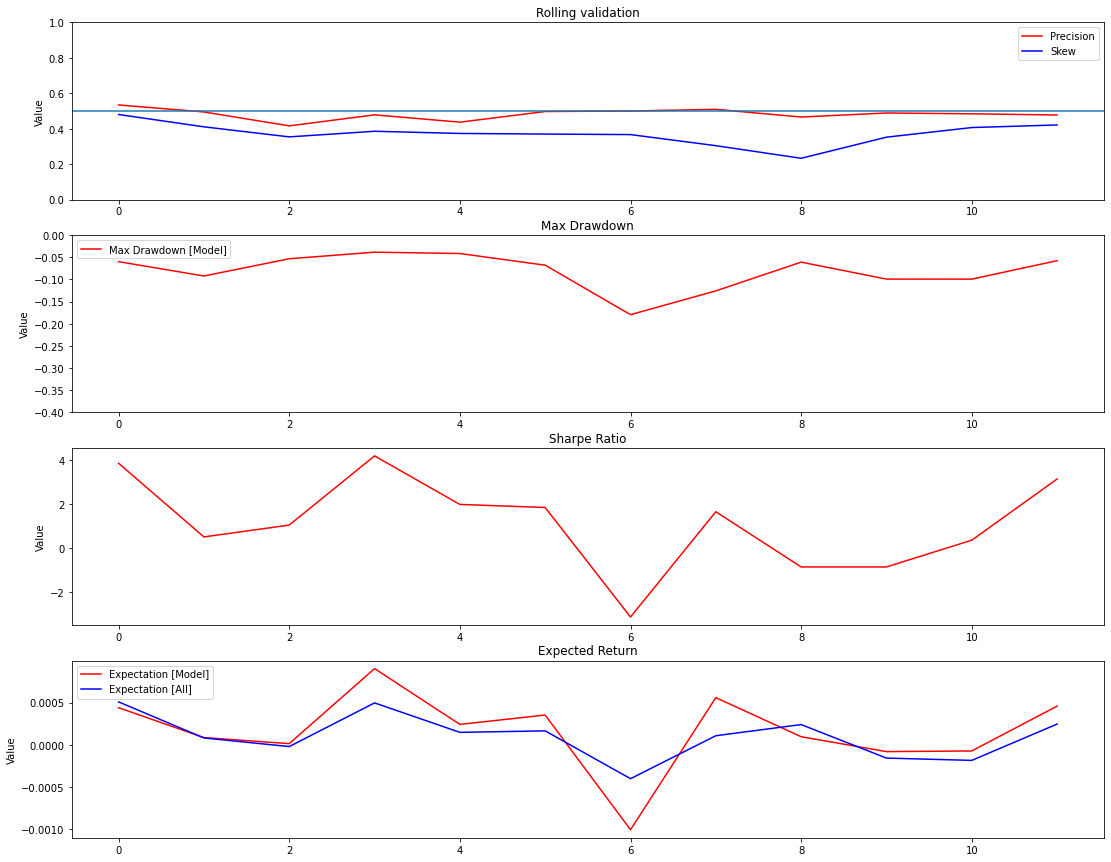

In [44]:
# Plot results
fig, axs = plt.subplots(4,1)
fig.set_size_inches(18.5, 15)

# Create the  plot
axs[0].plot(range(0,12), Rolling_Results['precision'], color = 'r',label = 'Precision')
axs[0].plot(range(0,12), Rolling_Results['testskew'], color = 'b',label = 'Skew')
axs[0].axhline(y=0.5)
axs[0].set_ylabel('Value')
axs[0].set_title('Rolling validation')
# axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])

axs[1].plot(range(0,12), Rolling_Results['max_dd_model'], color = 'r',label = 'Max Drawdown [Model]')
# axs[0].plot(range(0,12), Rolling_Results['testskew'], color = 'b',label = 'Skew')
axs[1].set_ylabel('Value')
axs[1].set_title('Max Drawdown')
# axs[0].set_xlim([0,1])
axs[1].set_ylim([-0.4,0])

axs[2].plot(range(0,12), Rolling_Results['sharpe_model'], color = 'r',label = 'Sharpe [Model]')
# axs[0].plot(range(0,12), Rolling_Results['testskew'], color = 'b',label = 'Skew')
axs[2].set_ylabel('Value')
axs[2].set_title('Sharpe Ratio')
# axs[0].set_xlim([0,1])
# axs[2].set_ylim([-0.4,0])

axs[3].plot(range(0,12), Rolling_Results['Model Exp'], color = 'r',label = 'Expectation [Model]')
axs[3].plot(range(0,12), Rolling_Results['Exp'], color = 'b',label = 'Expectation [All]')
axs[3].set_ylabel('Value')
axs[3].set_title('Expected Return')
# axs[0].set_xlim([0,1])
# axs[2].set_ylim([-0.4,0])


axs[0].legend(loc='upper right')
axs[1].legend(loc='upper left')
axs[3].legend(loc='upper left')